Paquetes necesarios

In [4]:
import cv2  
import numpy as np
import matplotlib.pyplot as plt
import csv

#Identificación de monedas

Carga imagen y convierte a RGB

(938, 473, 3)


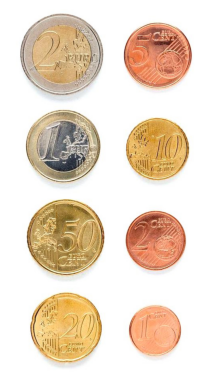

In [3]:
#Carga imagen ejemplo con monedas
img = cv2.imread('Monedas.jpg') 
print(img.shape)
#Recordar que OpenCV lee las imágenes en BGR, por lo que convertimos para visualizr a RGB
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.axis("off")
plt.imshow(img_rgb) 
plt.show()

Convierte a gris y muestra histograma

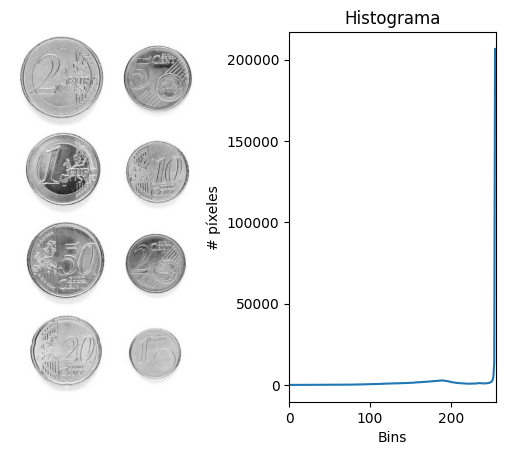

In [3]:
#Convierte la imagen a todos de gris, mostrando el resultado
img_gris = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

#Cálculo del histograma con 256 bins de una imagen en escala de grises
hist = cv2.calcHist([img_gris], [0], None, [256], [0, 256])

plt.figure()
plt.subplot(1, 2, 1)
plt.axis("off")
plt.imshow(img_gris, cmap='gray')

# Histograma sin normalizar
plt.subplot(1, 2, 2)
plt.title("Histograma")
plt.xlabel("Bins")
plt.ylabel("# píxeles")
plt.plot(hist)
plt.xlim([0, 256])
# Separo subplots horizontalmente
plt.subplots_adjust(wspace=0.4)

Cuenta resultado tras umbralizar (poniendo a negro el fondo)

Umbral fijo usado  200.0
Umbral Otsu  204.0


Text(0.5, 1.0, 'OTSU invertida')

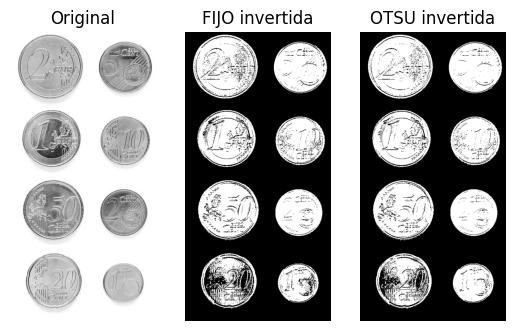

In [4]:
#Dos variantes de umbralizado. Probar otros parámetros, aplicar filtro previo, etc.
umbral = 200 # Prueba varios comenzando en 130
# Umbralizado binario invertido, dado que por defecto se asume objetos en blanco
th1,img_th1 = cv2.threshold(img_gris,umbral,255,cv2.THRESH_BINARY_INV)
print('Umbral fijo usado ', th1)
# Umbralizado con método de Otsu para selección automática del umbral
th2,img_th2 = cv2.threshold(img_gris,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
print('Umbral Otsu ', th2)

plt.subplot(1, 3, 1)
plt.axis("off")
plt.imshow(img_gris,cmap='gray') 
plt.title('Original')

plt.subplot(1, 3, 2)
plt.axis("off")
plt.imshow(img_th1,cmap='gray') 
plt.title('FIJO invertida')

plt.subplot(1, 3, 3)
plt.axis("off")
plt.imshow(img_th2,cmap='gray') 
plt.title('OTSU invertida')



Búsqueda de componentes y sus contornos

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


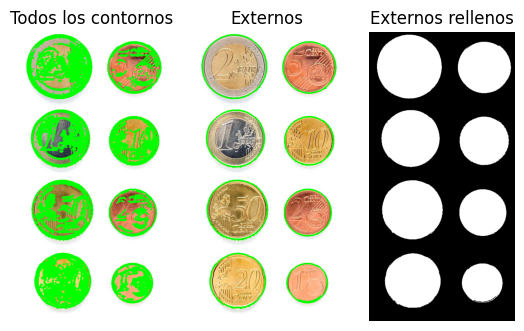

In [5]:
#Localiza contornos en imagen obtenida con umbral fijo
#findContours está diseñada para imágenes con  figura en blanco y fondo negro
#La imagen de entrada debe ser de un canal y 8 bits excepto en los modos RETR_CCOMP o RETR_FLOODFILL
#hierarchy contiene información sobre el nivel del contorno, relaciones paterno-filiales (contornos contenidos en otros)

#Obtiene todos los contornos: externos e internos
contornos, hierarchy = cv2.findContours(
    img_th1, #imagen
    cv2.RETR_TREE, #Modo de recuperación (lista, árbol, nivel superior)
    cv2.CHAIN_APPROX_SIMPLE #Método de aproximación del contorno
    )

#Dibuja sobre la imagen de entrada los contornos en verde
#Cada vez que quiere pintar convierte img para no tener restos
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
cv2.drawContours(img_rgb, contornos, -1, (0,255,0), 3)

plt.subplot(131)
plt.axis("off")
plt.imshow(img_rgb) 
plt.title('Todos los contornos')

#Obtiene únicamente los contornos externos
contornos2, hierarchy2 = cv2.findContours(img_th1, 
    cv2.RETR_EXTERNAL , 
    cv2.CHAIN_APPROX_SIMPLE)

#Dibuja sobre la imagen de entrada sólo contornos externos
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
cv2.drawContours(img_rgb, contornos2, -1, (0,255,0), 3)

plt.subplot(132)
plt.axis("off")
plt.imshow(img_rgb) 
plt.title('Externos')

#Dibuja contornos externos rellenos en imagen vacía
#Imagen negra
img_cont = np.zeros(img_rgb.shape)
#Recorre los contornos externos
for c in contornos2:
    #Área del contorno
    area = cv2.contourArea(c)
    #Área mínima (útil filtrar en ocasiones)
    if area > 10:
        #Perímetro del contorno
        perimetro = cv2.arcLength(c,True)
        #Contenedor alineado con ejes de la imagen
        x,y,w,h = cv2.boundingRect(c)
        #Mínimo contenedor ajustado para el contorno
        rect = cv2.minAreaRect(c)
        #Mínimo círculo que contiene al contorno
        (cx,cy),radio = cv2.minEnclosingCircle(c)
        #Elipse ajustada al contorno, exgigiendo un mínimo de puntos del contornos
        if c.shape[0] > 5:
            elipse = cv2.fitEllipse(c)
            #Para determinadas tareas nos puede interesará mostrar los valores obtenidos del contorno
            #print(area, perimetro, rect, cx,cy,radio, elipse)

        #Dibuja los contornos
        cv2.drawContours(img_cont, [c], -1, (255,255,255), -1)

plt.subplot(133)
plt.axis("off")
plt.imshow(img_cont) 
plt.title('Externos rellenos')
plt.show()


Alternativa contando círculos utilizando la Transformada de Hough. La selección de parámetros puede ser "divertida", más [información](https://docs.opencv.org/4.x/da/d53/tutorial_py_houghcircles.html)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


8
[[130.5 113.5 104.5]
 [140.5 579.5  91.1]
 [141.5 806.5  89.8]
 [127.5 346.5  87.3]
 [373.5 117.5  80.8]
 [370.5 353.5  77.4]
 [369.5 586.5  75.1]
 [366.5 815.5  65.7]]


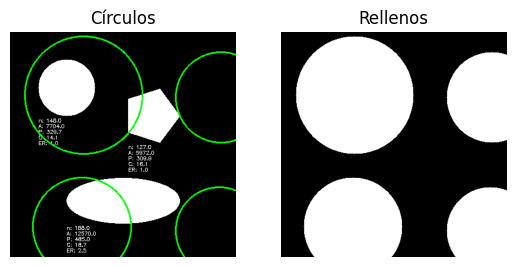

In [28]:
#Conversión a gris
#gris = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#Suaviza imagen (elimina altas frecuencias)
pimg = cv2.medianBlur(gris, 7)
#Localiza Círculos
circ = cv2.HoughCircles(
        pimg,  # imagen 
        cv2.HOUGH_GRADIENT,  # tipo de detección
        1,
        100,  # distancia mínima entre círculos
        param1=100, # valor del gradiente
        param2=50, # umbral acumulador
        minRadius=50,  # radio mínimo
        maxRadius=150,  # radio máximo
    )

#Dibuja sobre entrada e imagen vacía
img_cont = np.zeros(img_rgb.shape)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
for det in circ[0]:
        x_coor, y_coor, det_radio = det
        cv2.circle(img_rgb,(int(x_coor), int(y_coor)),
            int(det_radio),(0, 255, 0), 2)
        cv2.circle(img_cont,(int(x_coor), int(y_coor)),
            int(det_radio),(255, 255, 255), -1)

print(len(circ[0])) # num monedas

print(circ[0])

#Muestra resultado
plt.subplot(121)
plt.axis("off")
plt.imshow(img_rgb) 
plt.title('Círculos')

plt.subplot(122)
plt.axis("off")
plt.imshow(img_cont) 
plt.title('Rellenos')

plt.show()

Las formas localizadas tienen distintas características geométricas, que pueden estimarse a partir de sus contornos. Más información en la [documentación de OpenCV](https://docs.opencv.org/4.x/dd/d49/tutorial_py_contour_features.html).

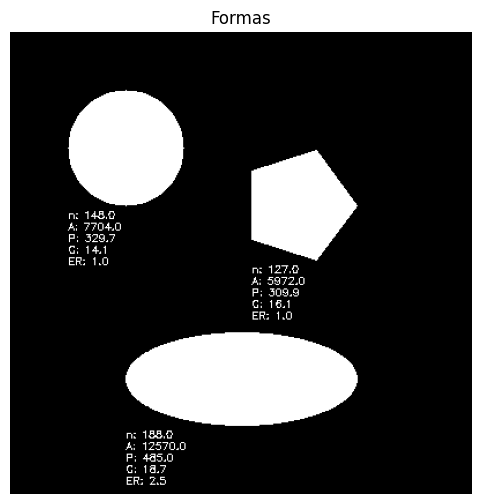

In [16]:
#Creación de polígono regular
def poligono_regular(image, ctr, radio, lados, color):
    pts = []
    ang_step = 2 * np.pi / lados
    for i in range(lados):
        ang = i * ang_step
        x = int(ctr[0] + radio * np.cos(ang))
        y = int(ctr[1] + radio * np.sin(ang))
        pts.append((x, y))
    pts = np.array(pts, np.int32)
    #regorganiza
    pts = pts.reshape((-1, 1, 2))
    cv2.fillPoly(image, [pts], color=color)

# Imagen vacía
img = np.zeros((400, 400, 1), dtype="uint8")
color = (255, 255, 255)

# Formas básicas
cv2.circle(img, (100, 100), 50, color, -1)  # Circular
poligono_regular(img, (250, 150), 50, 5, color)  # Polígono regular
cv2.ellipse(img, (200, 300), (100, 40), 0, 0, 360, color, -1)  # Elíptica

# Localiza contornos
contours, _ = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Parámeros texto
font = cv2.FONT_HERSHEY_SIMPLEX
font_scale = 0.3
thickness = 1

# Process each contour to calculate compactness and ellipse ratio (if possible)
for c in contours:
    # Puntos del contorno
    clon = len(c)

    # Área y perímetro
    area = cv2.contourArea(c)
    perimetro = cv2.arcLength(c, True)

    #Contenedor alineado con ejes de la imagen
    x,y,w,h = cv2.boundingRect(c)
    
    # Compactness: 4*pi*Area/Perimeter^2
    if perimetro > 0:
        compacidad = (perimetro ** 2) / area
    else:
        compactness = 0
    
    # Ajusta elipse si hay suficientes puntos
    if clon >= 5:
        elipse = cv2.fitEllipse(c)
        (center, axes, orientation) = elipse
        major_axis = max(axes)
        minor_axis = min(axes)
        elipse_ratio = major_axis / minor_axis
    else:
        elipse_ratio = None
    
    # Muestra valores en imageb
    cv2.putText(img, f"n: {clon:.1f}", (x, int(y+h+10)), font, font_scale, (255, 255, 255), thickness)
    cv2.putText(img, f"A: {area:.1f}", (x, int(y+h+20)), font, font_scale, (255, 255, 255), thickness)
    cv2.putText(img, f"P: {perimetro:.1f}", (x, int(y+h+30)), font, font_scale, color, thickness)
    cv2.putText(img, f"C: {compacidad:.1f}", (x, int(y+h+40)), font, font_scale, color, thickness)
    cv2.putText(img, f"ER: {elipse_ratio:.1f}", (x, int(y+h+50)), font, font_scale, color, thickness)
    
# Visualiza la imagen
plt.figure(figsize=(6, 6))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title("Formas")
plt.axis('off')
plt.show()


TAREA: Los ejemplos ilustrativos anteriores permiten saber el número de monedas presentes en la imagen. ¿Cómo saber la cantidad de dinero presente en ella? Sugerimos identificar de forma interactiva (por ejemplo haciendo clic en la imagen) una moneda de un valor determinado en la imagen (por ejemplo de 1€). Tras obtener esa información y las dimensiones en milímetros de las distintas monedas, realiza una propuesta para estimar la cantidad de dinero en la imagen. Muestra la cuenta de monedas y dinero sobre la imagen. No hay restricciones sobre utilizar medidas geométricas o de color. 

Una vez resuelto el reto con la imagen ideal proporcionada, captura una o varias imágenes con monedas. Aplica el mismo esquema, tras identificar la moneda del valor determinado, calcula el dinero presente en la imagen. ¿Funciona correctamente? ¿Se observan problemas?

Nota: Para establecer la correspondencia entre píxeles y milímetros, comentar que la moneda de un euro tiene un diámetro de 23.25 mm. la de 50 céntimos de 24.35, la de 20 céntimos de 22.25, etc. 

Extras: Considerar que la imagen pueda contener objetos que no son monedas y/o haya solape entre las monedas. Demo en vivo. 



In [ ]:
gris = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#Suaviza imagen (elimina altas frecuencias)
pimg = cv2.medianBlur(gris, 7)
#Localiza Círculos
circ = cv2.HoughCircles(
        pimg,  # imagen 
        cv2.HOUGH_GRADIENT,  # tipo de detección
        1,
        100,  # distancia mínima entre círculos
        param1=100, # valor del gradiente
        param2=50, # umbral acumulador
        minRadius=50,  # radio mínimo
        maxRadius=150,  # radio máximo
    )
#Dibuja sobre entrada e imagen vacía
img_cont = np.zeros(img_rgb.shape)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
cv2.putText(img_cont, "Numero de monedas: " + str(len(circ[0])), (10, 920), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 1)
diameters = []
for det in circ[0]:
        x_coor, y_coor, det_radio = det
        cv2.circle(img_rgb,(int(x_coor), int(y_coor)),
            int(det_radio),(0, 255, 0), 2)
        cv2.circle(img_cont,(int(x_coor), int(y_coor)),
            int(det_radio),(255, 255, 255), -1)
        diameters.append({"x": det[0], "y": det[1], "diameter":float(det[-1]*2)}) #calculo de los diametros de la imagen

#Muestra resultado
result_mas_cercano = {}
def mouse_click(event, x, y, flags, param):
        if event == cv2.EVENT_LBUTTONDOWN:
            coin = None
            ox = int(x / param["scale_x"])
            oy = int(y / param["scale_y"])
            for (cx, cy, r) in param["coins"]:
                if (ox - cx)**2 + (oy - cy)**2 <= r**2:
                    coin = (int(cx), int(cy), int(r))
                    break
            euro_diameter = coin[-1]*2
            print(euro_diameter)
            for diameter in param["diameters"]:
                  proportion = euro_diameter/diameter["diameter"]
                  res = buscar_con_tolerancia(param["proportions"], proportion)
                  result_mas_cercano = buscar_mas_cercano(param["proportions"], proportion) #calcula por mas cercano 
                  #print(proportion)
                  print(result_mas_cercano)
                  #print(res)
                  count_coins(result_mas_cercano)

#crea diccionario 
def buscar_con_tolerancia(dic, valor, tolerancia=0.03):
    rango_min = valor - tolerancia
    rango_max = valor + tolerancia
    return {k: v for k, v in dic.items() if rango_min <= k <= rango_max}

def buscar_mas_cercano(dic, valor):
    clave_mas_cercana = min(dic.keys(), key=lambda k: abs(k - valor)) #1.24 
    return {clave_mas_cercana: dic[clave_mas_cercana]}    

#realiza la suma 

def count_coins(result_diameters):
    result = 0
    for coin in result_diameters.values() :
        result += coin_names[coin]
    print("la suma de las monedas es:"+str(result))

#print(diameters)
# Mostrar en una sola ventana
size = (300, 600)
proportions = {
  1.43: '1cent',
  1.24: '2cent',
  1.09: '5cent',
  1.18: '10cent',
  1.04: '20cent',
  0.96: '50cent',
  0.90: '2eur'
}
coin_names = {
'1cent': 0.01,
'2cent': 0.02,
'5cent': 0.05,
'10cent': 0.10,
'20cent': 0.20,
'50cent': 0.50,
'2eur': 2,
'1eur': 1

}
result = 0
scale_x = size[0]/len(img[0])
scale_y = size[1]/len(img)
img_to_show = cv2.resize(img, size)
conts_to_show = cv2.resize(img_cont, size)
circs_img = cv2.imshow("Círculos", img_to_show)
conts_img = cv2.imshow("Contornos", conts_to_show)
cv2.setMouseCallback("Círculos", mouse_click, {"coins": circ[0], "proportions": proportions, "diameters": sorted(diameters, key=(lambda x: x["diameter"])), "scale_x":scale_x, "scale_y": scale_y})

cv2.waitKey(0)
cv2.destroyAllWindows()

plt.show()

174
{1.24: '2cent'}
la suma de las monedas es:0.02
{1.18: '10cent'}
la suma de las monedas es:0.1
{1.09: '5cent'}
la suma de las monedas es:0.05
{1.09: '5cent'}
la suma de las monedas es:0.05
{0.96: '50cent'}
la suma de las monedas es:0.5
{0.96: '50cent'}
la suma de las monedas es:0.5
{0.96: '50cent'}
la suma de las monedas es:0.5
{0.9: '2eur'}
la suma de las monedas es:2


#Clasificación de microplásticos

El mundo real es muy variado, las imágenes no siempre se capturan con unas condiciones de iluminación tan buenas o controladas. Ejemplo con aplicación de variantes de umbralizados ofrecidas por OpenCV sobre una imagen de muestras de microplásticos.

In [8]:
gris = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#Suaviza imagen (elimina altas frecuencias)
pimg = cv2.medianBlur(gris, 7)
#Localiza Círculos
circ = cv2.HoughCircles(
        pimg,  # imagen 
        cv2.HOUGH_GRADIENT,  # tipo de detección
        1,
        100,  # distancia mínima entre círculos
        param1=100, # valor del gradiente
        param2=50, # umbral acumulador
        minRadius=50,  # radio mínimo
        maxRadius=150,  # radio máximo
    )
#Dibuja sobre entrada e imagen vacía
img_cont = np.zeros(img_rgb.shape)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
cv2.putText(img_cont, "Numero de monedas: " + str(len(circ[0])), (10, 920), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 1)

diameters = []

for det in circ[0]:
        x_coor, y_coor, det_radio = det
        cv2.circle(img_rgb,(int(x_coor), int(y_coor)),
            int(det_radio),(0, 255, 0), 2)
        cv2.circle(img_cont,(int(x_coor), int(y_coor)),
            int(det_radio),(255, 255, 255), -1)
        diameters.append({"x": det[0], "y": det[1], "diameter":float(det[-1]*2)}) #calculo de los diametros de la imagen


proportions = {
  1.43: '1cent',
  1.24: '2cent',
  1.09: '5cent',
  1.18: '10cent',
  1.04: '20cent',
  0.96: '50cent',
  0.90: '2eur'
}
coin_names = {
'1cent': 0.01,
'2cent': 0.02,
'5cent': 0.05,
'10cent': 0.10,
'20cent': 0.20,
'50cent': 0.50,
'2eur': 2,
'1eur': 1

}


result = 0
reference_diameter = None

# metodo para buscar la moneda que mas se ajusta al diametro
def buscar_mas_cercano(dic, valor):
    clave_mas_cercana = min(dic.keys(), key=lambda k: abs(k - valor))
    return {clave_mas_cercana: dic[clave_mas_cercana]}    

#metodo de suma 
def count_coins(result_diameters):
    global result
    for coin in result_diameters.values() :
        result += coin_names[coin]
    print("la suma de las monedas es:"+str(result))

def mouse_click(event, x, y, flags, param):
    global reference_diameter
    if event == cv2.EVENT_LBUTTONDOWN:
        coins = param["coins"]
        proportions = param["proportions"]

        # Buscar moneda clicada según coordenadas (en escala original)
        coin = None
        for (cx, cy, r) in coins:
            if (x - cx)**2 + (y - cy)**2 <= r**2:
                coin = (cx, cy, r)
                break

        if coin is None:
            print("No se detectó ninguna moneda en el clic.")
            return

        coin_diameter = coin[-1] * 2
        print(f"Diámetro clicado: {coin_diameter:.2f}px")

        # Primer clic: seleccionar moneda de referencia
        if reference_diameter is None:
            reference_diameter = coin_diameter
            print("Moneda seleccionada como referencia (escala base).")
            return

        # Clics siguientes: comparar proporción con referencia
        proportion = reference_diameter / coin_diameter
        coin_name = buscar_mas_cercano(proportions, proportion)
        count_coins(coin_name)

# --- Mostrar resultados sin reescalar ---
cv2.imshow("Círculos", img_rgb)
cv2.imshow("Contornos", img_cont)

# Configurar el callback (sin escalas)
cv2.setMouseCallback("Círculos",mouse_click,{"coins": circ[0],"proportions": proportions})

print(" Haz clic primero en una moneda de referencia (por ejemplo, 2€).")
print("Luego haz clic en las demás monedas para identificarlas y sumarlas.\n")

cv2.waitKey(0)
cv2.destroyAllWindows()



 Haz clic primero en una moneda de referencia (por ejemplo, 2€).
Luego haz clic en las demás monedas para identificarlas y sumarlas.

Diámetro clicado: 174.60px
Moneda seleccionada como referencia (escala base).
Diámetro clicado: 174.60px
la suma de las monedas es:0.2
Diámetro clicado: 209.00px
la suma de las monedas es:2.2
Diámetro clicado: 161.60px
la suma de las monedas es:2.25
Diámetro clicado: 154.80px
la suma de las monedas es:2.3
Diámetro clicado: 182.20px
la suma de las monedas es:2.8
Diámetro clicado: 150.20px
la suma de las monedas es:2.9
Diámetro clicado: 150.20px
la suma de las monedas es:3.0


In [2]:
import cv2
import numpy as np

# --- Cargar y preparar imagen ---
img = cv2.imread('monedas.jpg')
gris = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
pimg = cv2.medianBlur(gris, 7)


circ = cv2.HoughCircles(
    pimg,
    cv2.HOUGH_GRADIENT,
    1,
    100,
    param1=100,
    param2=50,
    minRadius=50,
    maxRadius=150,
)

if circ is None:
    print("No se detectaron círculos.")
    exit()

# --- Preparación de imágenes ---
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_cont = np.zeros(img_rgb.shape, dtype=np.uint8)

# --- Datos de referencia Calculados como diamtreo-1-euro/diametro-x---
proportions = {
    1.43: '1cent',
    1.24: '2cent',
    1.09: '5cent',
    1.18: '10cent',
    1.04: '20cent',
    0.96: '50cent',
    0.90: '2eur'
}
# Diccioanrio con el nombre de las monedas y su valor
coin_values = {
    '1cent': 0.01,
    '2cent': 0.02,
    '5cent': 0.05,
    '10cent': 0.10,
    '20cent': 0.20,
    '50cent': 0.50,
    '1eur': 1.00,
    '2eur': 2.00
}

reference_diameter = None

# --- Función buscadora ---
def buscar_mas_cercano(dic, valor):
    clave_mas_cercana = min(dic.keys(), key=lambda k: abs(k - valor))
    return dic[clave_mas_cercana]


def mouse_click(event, x, y, flags, param):
    global reference_diameter

    if event == cv2.EVENT_LBUTTONDOWN:
        coins = param["coins"]
        proportions = param["proportions"]

        # Buscar moneda clicada
        coin_clicked = None
        for (cx, cy, r) in coins:
            if (x - cx)**2 + (y - cy)**2 <= r**2:
                coin_clicked = (cx, cy, r)
                break

        if coin_clicked is None:
            print("No se detectó ninguna moneda en el clic.")
            return

        # Guardar diámetro de referencia
        reference_diameter = coin_clicked[-1] * 2
        print(f"Moneda seleccionada como referencia: diámetro = {reference_diameter:.2f}px")

        # --- Calcular todas las monedas ---
        total = 0
        resultados = []

        for (cx, cy, r) in coins:
            d = r * 2
            proportion = reference_diameter / d
            coin_name = buscar_mas_cercano(proportions, proportion)
            valor = coin_values.get(coin_name, 0)
            total += valor
            resultados.append((cx, cy, r, coin_name, valor))
            print(f"Moneda detectada: {coin_name} ({valor:.2f}€)")

        print(f"\n TOTAL DETECTADO: {total:.2f} €")

        # Dibujar resultado
        output = img_rgb.copy()
        for (cx, cy, r, name, val) in resultados:
            cv2.circle(output, (int(cx), int(cy)), int(r), (0, 255, 0), 2)
            cv2.putText(output, f"{name}", (int(cx) - 40, int(cy)),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)

        cv2.putText(output, f"TOTAL: {total:.2f} EUR", (50, 50),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 3)

        cv2.imshow("Resultado", cv2.cvtColor(output, cv2.COLOR_RGB2BGR))

# --- Dibujar círculos detectados antes del clic ---
for (x, y, r) in circ[0]:
    cv2.circle(img_rgb, (int(x), int(y)), int(r), (0, 255, 0), 2)

cv2.imshow("Monedas detectadas", cv2.cvtColor(img_rgb, cv2.COLOR_RGB2BGR))
cv2.setMouseCallback("Monedas detectadas", mouse_click, {"coins": circ[0], "proportions": proportions})

print(" Haz clic en la moneda de referencia 1€.")
print("El programa identificará automáticamente todas las demás monedas y mostrará el total.\n")

cv2.waitKey(0)
cv2.destroyAllWindows()


 Haz clic en la moneda de referencia 1€.
El programa identificará automáticamente todas las demás monedas y mostrará el total.

Moneda seleccionada como referencia: diámetro = 174.60px
Moneda detectada: 2eur (2.00€)
Moneda detectada: 50cent (0.50€)
Moneda detectada: 50cent (0.50€)
Moneda detectada: 20cent (0.20€)
Moneda detectada: 5cent (0.05€)
Moneda detectada: 5cent (0.05€)
Moneda detectada: 10cent (0.10€)
Moneda detectada: 2cent (0.02€)

 TOTAL DETECTADO: 3.42 €


Umbral escogido  197.0


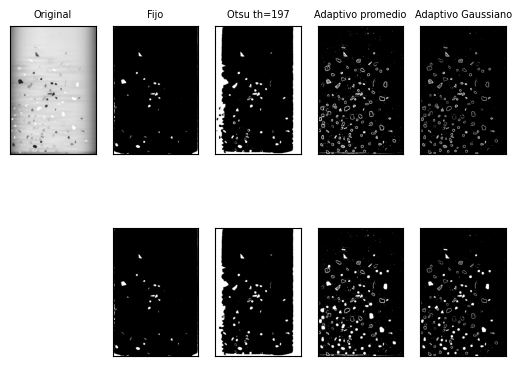

In [ ]:
#Carga imagen directamente en grises
imgorig = cv2.imread('MPs_test.jpg', cv2.IMREAD_GRAYSCALE) 

img = cv2.GaussianBlur(imgorig,(5,5),0)

#Umbralizados
ret,imth1 = cv2.threshold(img,150,255,cv2.THRESH_BINARY_INV)
thotsu,imth2 = cv2.threshold(img,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
print('Umbral escogido ', thotsu)
imth3 = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_MEAN_C,\
            cv2.THRESH_BINARY,11,2)
imth4 = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv2.THRESH_BINARY,11,2)
 
titles = ['Original', 'Fijo','Otsu th='+str(int(thotsu)),
            'Adaptivo promedio', 'Adaptivo Gaussiano']
images = [img, imth1, imth2, 255 - imth3, 255 - imth4]
 
for i in range(5):
    plt.subplot(2,5,i+1),plt.imshow(images[i],'gray')
    plt.title(titles[i], fontsize=7)
    plt.xticks([]),plt.yticks([])

    #Obtiene únicamente los contornos externos
    if i>0:
        res,imth = cv2.threshold(images[i],120,255,cv2.THRESH_BINARY)
        contornos, hierarchy= cv2.findContours(imth, 
        cv2.RETR_EXTERNAL , 
        cv2.CHAIN_APPROX_SIMPLE)  
        img_cont = np.zeros(img.shape)
        cv2.drawContours(img_cont, contornos, -1, (255,255,255), -1)  
        plt.subplot(2,5,i+6),plt.imshow(img_cont,'gray')
        plt.xticks([]),plt.yticks([])
plt.show()

Para esta imagen de muestras de microplásticos tenemos una anotación (que puede contener errores) de la tipología de las partículas. Esta será la imagen de test en los experimentos posteriores, no puedes hacer uso de esta imagen para entrenar tu clasificador, solo par evaluarlo

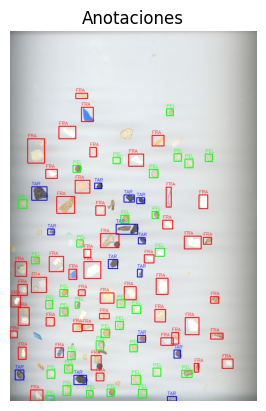

In [5]:
# Imagen y anotaciones
imagen = "MPs_test.jpg"          # Imagen original
csv_file = "MPs_test_bbs.csv"  # CSV con coordenadas y tipología

# Colores de cada clase
colores = {
    "FRA": (0, 0, 255),   # Rojo 
    "PEL": (0, 255, 0),   # Verde
    "TAR": (255, 0, 0)    # Azul
}

# Imagen
img = cv2.imread(imagen)

# Cara csv y dibujar rectángulos
with open(csv_file, newline="") as file:
    reader = csv.DictReader(file)
    for row in reader:
        etiqueta = row["label"]
        x_min, y_min, x_max, y_max = map(int, [row["x_min"], row["y_min"], row["x_max"], row["y_max"]])
        
        # Color según etiqueta
        color = colores.get(etiqueta, (0, 0, 0))  # negro por defecto si no encuentra
        
        # Dibujar rectángulo
        cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color, 2)
        
        # Etiqueta 
        cv2.putText(img, etiqueta, (x_min, y_min - 5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)

# Visualiza resultado
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title("Anotaciones")
plt.axis('off')
plt.show()


##Muestras de entrenamiento

Text(0.5, 1.0, 'Alquitrán')

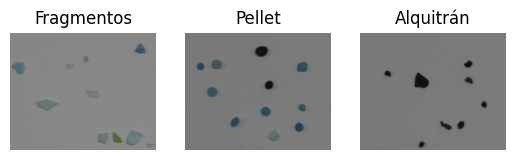

In [6]:
#Cargamos tres subimágenes, por simplicidad, de cada uno de los tres tipos considerados (el alquitrán no es microplástico)
imgF = cv2.imread('FRA.png') 
imgP = cv2.imread('PEL.png') 
imgT = cv2.imread('TAR.png') 

#Mostramos
plt.subplot(131)
plt.axis("off")
plt.imshow(imgF) 
plt.title('Fragmentos')
plt.subplot(132)
plt.axis("off")
plt.imshow(imgP) 
plt.title('Pellet')
plt.subplot(133)
plt.axis("off")
plt.imshow(imgT) 
plt.title('Alquitrán')

El objetivo de la siguiente tarea, descrita más abajo, es desarrollar tu propio clasificador basado únicamente en heurísticas basadas en características geométricas y/o de apariencia, a partir de las imágenes completas de las partículas de cada tipo, debiendo mostrar la bondad del clasificador haciendo uso de métricas para ello sobre las anotaciones de la imagen de test *MPs_test.png*. La siguiente celda obtiene varias métricas para un conjunto de datos imaginario (y con etiquetas aleatorias). Si bien las trataremos con más detalle en teoría, muestro un repertorio de ellas, dando más peso a la matriz de confusión. La ejecución de la celda requiere instalar el paquete scikit-learn.

¿Qué es una matriz de confusión?
Se utiliza para mostrar el comportamiento de un clasificador para las distintas clases conocidas, se relacionan las etiquetas de las muestras anotadas frente a las predichas por el clasificador. Se busca una matriz diagonal, pero la perfección es infrecuente.

El siguiente ejemplo, muestra el modo de obtener la matriz de confusión para un hipotético problema con cuatro clases, y valores de anotación (variable y) y predicción (variable y_pred) obtenidos de forma aleatoria.

Anotaciones  [0, 1, 3, 0, 3, 0, 1, 1, 0, 2, 3, 0, 2, 2, 1, 0, 0, 0, 2, 0, 3, 2, 3, 2, 0, 3, 0, 3, 1, 1, 1, 1, 0, 1, 1, 3, 2, 3, 0, 3, 1, 3, 3, 3, 3, 2, 0, 1, 1, 2, 3, 3, 0, 3, 1, 3, 0, 0, 2, 1, 2, 2, 3, 1, 2, 2, 3, 2, 0, 3, 0, 3, 1, 3, 3, 2, 0, 1, 3, 0, 2, 2, 0, 3, 1, 0, 1, 2, 0, 0, 1, 1, 2, 0, 0, 0, 2, 0, 2, 1]
Predicciones  [3, 1, 1, 1, 3, 3, 0, 3, 2, 2, 2, 3, 1, 3, 0, 0, 0, 2, 2, 2, 1, 0, 2, 0, 3, 2, 3, 2, 2, 3, 2, 3, 2, 0, 3, 3, 0, 1, 0, 1, 3, 2, 3, 3, 0, 1, 3, 1, 1, 1, 0, 0, 2, 1, 3, 2, 0, 1, 1, 3, 2, 0, 0, 1, 3, 3, 1, 3, 1, 3, 2, 0, 1, 0, 2, 0, 1, 2, 3, 2, 3, 3, 3, 1, 2, 2, 2, 1, 0, 3, 3, 0, 2, 0, 3, 3, 0, 2, 3, 2]
¿Cómo de bien encajan anotación y predicción?
Accuracy (TP/(n))= 0.21
Precision (TP/(TP+FP)) = 0.21802154834412896
Recall (TP/(TP+FN)) = 0.21
F1 Score (2*(precision*recall)/(precision+recall)) = 0.21191153016230416


Text(38.25, 0.5, 'Real/Anotado')

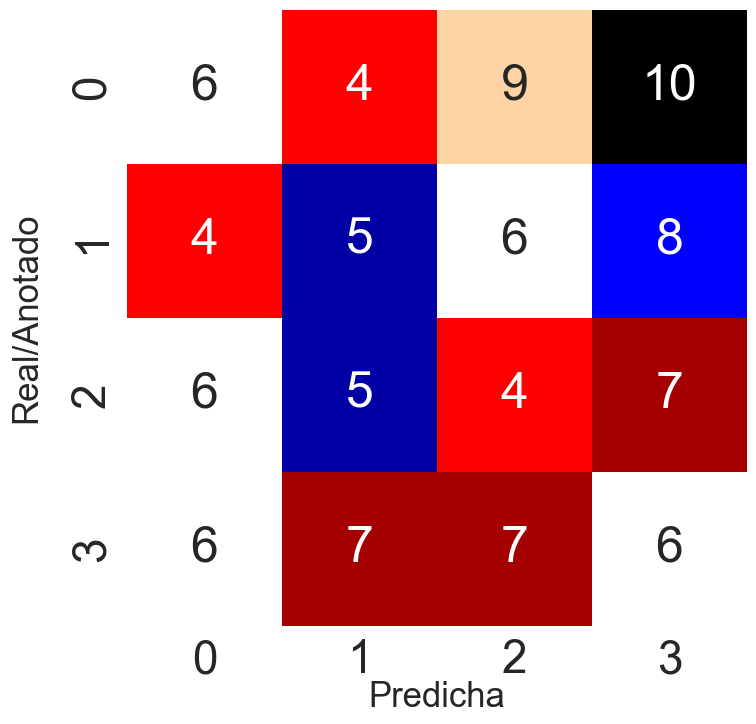

In [12]:

import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)


# Numero de muestras
n = 100  
nclases = 4

# A falta de clasificador y conjunto de datos, creamos anotaciones y predicciones de forma aleatoria
# Vector aleatorio con etiquetas anotadas
y = [random.randint(0, nclases - 1) for _ in range(n)]
print('Anotaciones ' , y)

# Vector aleatorio con etiquetas predichas por un supuesto clasificador
y_pred = [random.randint(0, nclases - 1) for _ in range(n)]
print('Predicciones ' , y_pred)

print('¿Cómo de bien encajan anotación y predicción?')

#Cálculo de métricas
accuracy = accuracy_score(y, y_pred)
#Para más de una clase se define la forma de promediar
precision = precision_score(y, y_pred,average='weighted')
recall = recall_score(y, y_pred,average='weighted')
f1score = f1_score(y, y_pred,average='weighted')

print(f"Accuracy (TP/(n))= {accuracy}")
print(f"Precision (TP/(TP+FP)) = {precision}")
print(f"Recall (TP/(TP+FN)) = {recall}")
print(f"F1 Score (2*(precision*recall)/(precision+recall)) = {f1score}")


conf_matrix = confusion_matrix(y, y_pred)
plt.figure(figsize=(8,8))
sns.set(font_scale = 1.75)#tamaños tipografía
sns.set(font_scale = 3.0)

ax = sns.heatmap(
        conf_matrix, # confusion matrix 2D array 
        annot=True, # Muestra números en las celdas
        fmt='d', # valores enteros
        cbar=False, # sin barra de colores
        cmap='flag', # mapa de colores
        #vmax=175 # contraste de color
    )

#Etiquetas matriz de confusión
label_font = {'size':'25'}
ax.set_xlabel("Predicha", labelpad=-0.75, fontdict=label_font)
ax.set_ylabel("Real/Anotado", labelpad=20, fontdict=label_font)

TAREA: La tarea consiste en extraer características (geométricas y/o visuales) de las tres imágenes completas de partida, y *aprender* patrones que permitan identificar las partículas en nuevas imágenes. Para ello se proporciona como imagen de test *MPs_test.jpg* y sus correpondientes anotaciones *MPs_test_bbs.csv* con la que deben obtener las métricas para su propuesta de clasificación de microplásticos, además de la matriz de confusión. La matriz de confusión permitirá mostrar para cada clase el número de muestras que se clasifican correctamente de dicha clase, y el número de muestras que se clasifican incorrectamente como perteneciente a una de las otras dos clases.

En el trabajo [SMACC: A System for Microplastics Automatic Counting and Classification](https://doi.org/10.1109/ACCESS.2020.2970498), las características geométricas utilizadas fueron:

- Área en píxeles
- Perímetro en píxeles
- Compacidad (relación entre el cuadrado del perímetro y el área de la partícula)
- Relación del área de la partícula con la del contenedor
- Relación del ancho y el alto del contenedor
- Relación entre los ejes de la elipse ajustada
- Definido el centroide, relación entre las distancias menor y mayor al contorno

Si no se quedan satisfechos con la segmentación obtenida, es el mundo real, también en el README comento técnicas recientes de segmentación, que podrían despertar su curiosidad.

FRA → [9415.0, 466.1320300102234, 23.07796807237692, 0.5779974215728406, 1.967032967011351, 0.49467409674153906, 0.39715482970689187]
PEL → [7239.5, 337.46298360824585, 15.730542897404996, 0.7547435362802335, 1.2386363636222881, 0.7812581688436354, 0.7205340582199588]
TAR → [9690.0, 408.47517585754395, 17.21898547903346, 0.6906628652886672, 0.9426229508119457, 0.8419784941028776, 0.5978975744784761]

Clasificando partículas en la imagen de test

--- Métricas de clasificación ---
Accuracy  : 0.351
Precision : 0.123
Recall    : 0.351
F1-score  : 0.182


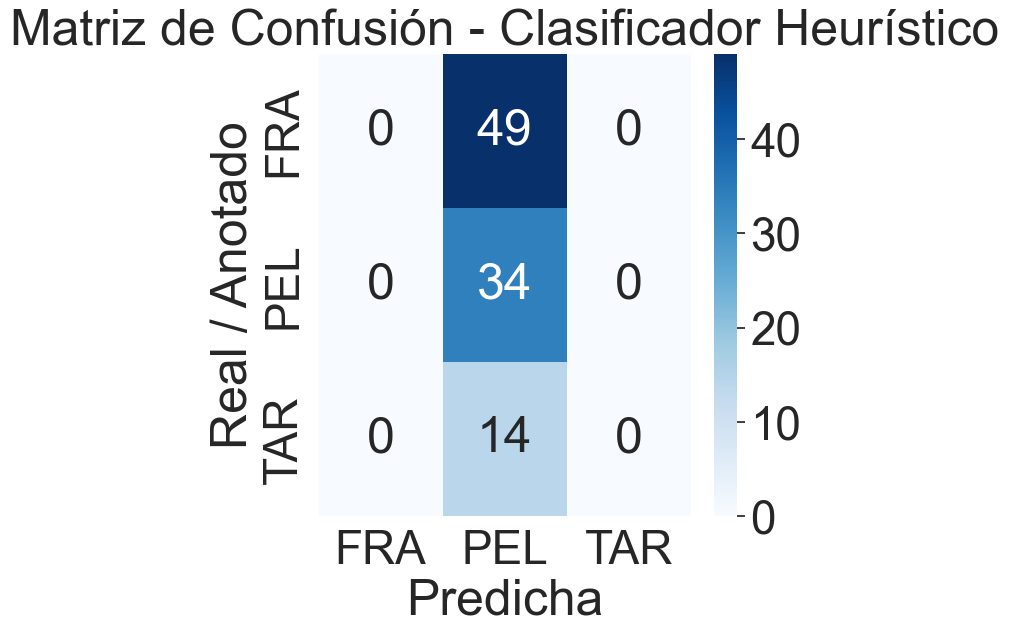

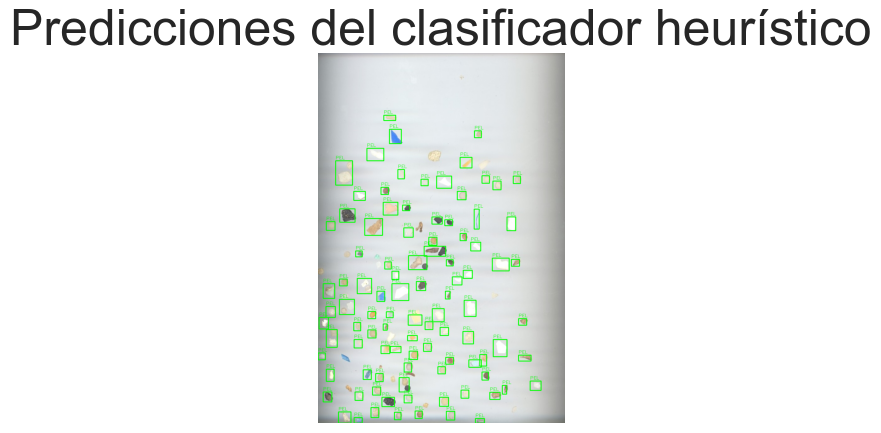

In [16]:
import cv2
import csv
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score


train_imgs = {
    "FRA": "FRA.png",
    "PEL": "PEL.png",
    "TAR": "TAR.png"
}

test_img_path = "MPs_test.jpg"
test_csv_path = "MPs_test_bbs.csv"

#  extraer características geométricas 
def extract_features(img):

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    _, mask = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    if np.mean(gray[mask == 255]) > np.mean(gray[mask == 0]):
        mask = cv2.bitwise_not(mask)

    
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return None
    cnt = max(contours, key=cv2.contourArea)

    x, y, w, h = cv2.boundingRect(cnt)
    area = cv2.contourArea(cnt)
    perimeter = cv2.arcLength(cnt, True)
    compacidad = (perimeter ** 2) / (area + 1e-9)
    rel_area_box = area / (w * h)
    aspect_ratio = w / (h + 1e-9)

    
    if len(cnt) >= 5:
        (_, _), (MA, ma), _ = cv2.fitEllipse(cnt)
        rel_ejes = MA / ma if ma > 0 else 0
    else:
        rel_ejes = 0

    M = cv2.moments(cnt)
    if M["m00"] != 0:
        cx = int(M["m10"] / M["m00"])
        cy = int(M["m01"] / M["m00"])
    else:
        cx, cy = 0, 0

    dists = [cv2.norm(np.array([cx, cy], dtype=np.float32) - p[0].astype(np.float32)) for p in cnt]
    rel_dist = min(dists) / (max(dists) + 1e-9) if len(dists) > 0 else 0

    return [area, perimeter, compacidad, rel_area_box, aspect_ratio, rel_ejes, rel_dist]




patterns = {}
for label, path in train_imgs.items():
    img = cv2.imread(path)
    if img is None:
        print(f"No se pudo cargar {path}")
        continue
    features = extract_features(img)
    if features is None:
        print(f"No se pudieron extraer características de {label}")
        continue
    patterns[label] = np.array(features)
    print(f"{label} → {features}")

if len(patterns) < 3:
    raise RuntimeError("No se pudieron generar todos los patrones de referencia.")

#  Clasificación sobre la imagen de test 
print("\nClasificando partículas en la imagen de test")

img_test = cv2.imread(test_img_path)
if img_test is None:
    raise FileNotFoundError(f"No se encontró la imagen {test_img_path}")

y_true = []
y_pred = []

# Leer CSV 
with open(test_csv_path, newline="") as file:
    reader = csv.DictReader(file)
    for row in reader:
        label = row["label"]
        x_min, y_min, x_max, y_max = map(int, [
            row["x_min"], row["y_min"], row["x_max"], row["y_max"]
        ])
        crop = img_test[y_min:y_max, x_min:x_max]
        features = extract_features(crop)
        if features is None:
            pred = "FRA"  # predeterminado si no se puede analizar
        else:
            # Distancia euclídea a cada patrón
            distances = {cls: np.linalg.norm(patterns[cls] - np.array(features))
                         for cls in patterns}
            pred = min(distances, key=distances.get)
        y_true.append(label)
        y_pred.append(pred)

# ---  Cálculo de métricas ---
print("\n--- Métricas de clasificación ---")
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

print(f"Accuracy  : {accuracy:.3f}")
print(f"Precision : {precision:.3f}")
print(f"Recall    : {recall:.3f}")
print(f"F1-score  : {f1:.3f}")

# Matriz de confusión
labels = ["FRA", "PEL", "TAR"]
cm = confusion_matrix(y_true, y_pred, labels=labels)

plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicha")
plt.ylabel("Real / Anotado")
plt.title("Matriz de Confusión - Clasificador Heurístico")
plt.show()

# Mostrar imagen con predicciones 
colores = {"FRA": (0, 0, 255), "PEL": (0, 255, 0), "TAR": (255, 0, 0)}

with open(test_csv_path, newline="") as file:
    reader = csv.DictReader(file)
    for i, row in enumerate(reader):
        x_min, y_min, x_max, y_max = map(int, [
            row["x_min"], row["y_min"], row["x_max"], row["y_max"]
        ])
        pred = y_pred[i]
        color = colores.get(pred, (0, 0, 0))
        cv2.rectangle(img_test, (x_min, y_min), (x_max, y_max), color, 2)
        cv2.putText(img_test, pred, (x_min, y_min - 5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)

plt.imshow(cv2.cvtColor(img_test, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title("Predicciones del clasificador heurístico")
plt.show()
